In [102]:
import torch
from PIL import Image
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch.nn.functional as F
from torchvision.ops import focal_loss
import torchvision.transforms.functional as transF
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os
from torch.utils.data import random_split
import random
from sklearn import preprocessing
from tqdm import tqdm
import cv2
import pandas as pd
from sklearn.metrics import confusion_matrix

In [103]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [104]:
class CFG:
    '''
    CFG
    Define hyperparameters used for preprocessing data and training model
    ----------
    Attributes
    ----------
        num_epochs: int 
            Number of epochs need for training.
        batch_size: int
            Number of samples used for training in 1 iteration.
        num_workers: int
            Number of processor used in multiprocessing training.
        weight_decay: float (0 < weight_decay < 1)
            Percentage of neuron dropped out.
        mean: ndarray
            Mean values of the whole dataset
        std: ndarray
            Standard deviation values of the whole dataset.
        height: int
            Height of input image used for the input layer of model.
        width: int
            Width of input image used for the input layer of model.
        learning_rate: float
            Step size at each iteration defines how much to change the model.
        num_classes: int
            Number of output classes.
        target_names: list(str) 
            Names of output classes.
    '''
    num_epochs = 10
    batch_size = 32
    num_workers = 2
    weight_decay = 1e-5
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    height = 224
    width = 224
    learning_rate = 0.001
    num_classes = 4
    le = preprocessing.LabelEncoder()
    path = './archive/data'
    stoi = {'cloudy' : 0, 'desert' : 1, 'green_area' : 2, 'water' : 3}
    itos = {0 :'cloudy', 1 : 'desert', 2 : 'green_area', 3 : 'water'}
    target_names = ['cloudy', 'desert', 'green_area', 'water']

In [105]:
class ProcessData:
    def __init__(self, path = CFG.path):
        self.path = path

    def random_split_dataset(self):
        '''
        random_split_dataset(path = CFG.path)
        Split the dataset into 3 subsets included: train, validation and test.
        ----------
        Parameters
        ----------
        path : str, default=CFG.path
            `path` define the path to dataset
        ----------
        Returns
        ----------
        tuple(list(str))
            Tuple including 3 lists: train, validation, test. Each list contains paths to samples in dataset.
            The default ratio for 3 subset: train=0.6, validation=0.2, test=0.2
        '''
        random.seed(42)
        folders = os.listdir(self.path)
        CFG.num_classes = len(folders)
        data = []
        CFG.le.fit(folders)
        CFG.le_name_mapping = dict(zip(CFG.le.classes_, CFG.le.transform(CFG.le.classes_)))
        for folder in folders:
            for image_filename in os.listdir(os.path.join(self.path, folder)):
                data.append((image_filename, folder))
        print('num_classes', CFG.num_classes, 'length dataset', len(data))
        CFG.train_size = int(0.8*len(data))
        CFG.valid_size = int(0.1*len(data))
        CFG.test_size = len(data) - CFG.train_size - CFG.valid_size
        random.shuffle(data)
        return data[ : CFG.train_size], data[CFG.train_size : CFG.train_size + CFG.valid_size], data[CFG.train_size + CFG.valid_size : ]

    def get_transforms(self, transforms_type: str):
        '''
        get_transforms(transforms_type)
        ----------
        Parameters
        ----------
        transforms_type: str
            Refers to which dataset transformation applied on ('train', 'test', 'train')
        ----------
        Returns
        ----------
            If mode is 'train': return a transform.Compose object including steps:
                Resize, RandomHorizontalFlip, RandomRotation, ToTensor, Normalize
            Else: return a transform.Compose object including steps:
                Resize, ToTensor, Normalize
        '''
        if transforms_type == 'train':
            return transforms.Compose([
                    transforms.Resize((CFG.width, CFG.height)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(30),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=CFG.mean,std=CFG.std)
                ])
        else:
            return transforms.Compose([
                transforms.Resize((CFG.width, CFG.height)),
                transforms.ToTensor(),
                transforms.Normalize(mean=CFG.mean,std=CFG.std)
            ])

In [106]:
class CustomDataset(Dataset):
    def __init__(self, data, transforms_type = 'train'):
        self.data = data
        self.transforms = ProcessData().get_transforms(transforms_type)
        
    def __getitem__(self, idx):
        '''
        __getitem__(self, idx)
        Get item by index
        ----------
        Parameters
        ----------
        idx: int
            Index of the sample in dataset.
        ----------
        Returns
        ----------
        A tuple of (image: tensor, label: numeric)
        '''
        image_filename, class_name = self.data[idx]
        img_path = os.path.join(CFG.path, class_name, image_filename)
        img = Image.open(img_path).convert("RGB")
        img = self.transforms(img)
        return img, torch.tensor(CFG.le_name_mapping[class_name])

    def __len__(self):
        return len(self.data)

In [107]:
class DatasetLoader:
    def __init__(self):
        self.process_data = ProcessData()

    def get_loaders(self):
        '''
        get_loaders: 
            Split the dataset into 3 set: train, val and test. Each set will be converted into a CustomDataset object and transformed.
            Divided each dataset into batches for data loading.
        ----------
        Returns
        ----------
        A tuple of (train_loader, val_loader, test_loader)
        '''
        train_data, val_data, test_data = self.process_data.random_split_dataset()
        print(len(train_data), len(val_data), len(test_data))
        train_dataset = CustomDataset(train_data, transforms_type = 'train')
        val_dataset = CustomDataset(val_data, transforms_type = 'valid')
        test_dataset = CustomDataset(test_data, transforms_type = 'test')
        train_loader = DataLoader(dataset = train_dataset, batch_size = CFG.batch_size, shuffle = True)
        val_loader = DataLoader(dataset = val_dataset, batch_size = CFG.batch_size, shuffle = False)
        test_loader = DataLoader(dataset = test_dataset, batch_size = CFG.batch_size, shuffle = False)
        return train_loader, val_loader, test_loader

In [108]:
train_loader, val_loader, test_loader = DatasetLoader().get_loaders()

num_classes 4 length dataset 5631
4504 563 564


In [109]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=CFG.weight_decay)

        self.conv1 = nn.Conv2d(3, 6, 4)
        self.conv2 = nn.Conv2d(6, 12, 4)
        self.conv3 = nn.Conv2d(12, 14, 4)
        self.conv4 = nn.Conv2d(14, 16, 4)
        self.conv5 = nn.Conv2d(16, 20, 4)

        self.fc1 = nn.Linear(20*4*4, 250)
        self.fc2 = nn.Linear(250, 200)
        self.fc3 = nn.Linear(200, 50)
        self.fc4 = nn.Linear(50, 20)
        self.fc5 = nn.Linear(20, CFG.num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv5(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.reshape(-1, 20*4*4)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc4(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc5(x)
        
        return x

In [125]:
class Trainer:
    def __init__(self, model):
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=CFG.learning_rate, weight_decay=CFG.weight_decay)

    def train(self, train_loader):
        self.model.train()
        train_acc, correct_train, train_loss, target_count = 0, 0, 0, 0
    
        for images, labels in tqdm(train_loader):
            images = images.to(device).float()
            labels = labels.to(device).long()

            # Forward pass
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            train_loss += loss.item()

            # Backward and optimize
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
                
            # accuracy
            _, predicted = torch.max(outputs, 1)
            target_count += labels.shape[0]
            correct_train += (labels == predicted).sum().item()
            train_acc = (100 * correct_train) / target_count
        return train_acc, train_loss / target_count

    def validate(self, val_loader):
        self.model.eval()
        val_acc, correct_val, val_loss, target_count = 0, 0, 0, 0
        for images, labels in tqdm(val_loader):
            images = images.to(device).float()
            labels = labels.to(device).long()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            target_count += labels.shape[0]
            correct_val += (labels == predicted).sum().item()
            val_acc = (100 * correct_val) / target_count
        return val_acc, val_loss / target_count 
    
    def fit(self, model, the_last_loss = 100, patience = 10, trigger_times = 0, isStopped = False):
        self.train_acc_history = []
        self.train_loss_history = []
        self.val_acc_history = []
        self.val_loss_history = []

        for epoch in range(0, CFG.num_epochs):
            
            train_acc, train_loss = self.train(train_loader)
            self.train_acc_history.append(train_acc)
            self.train_loss_history.append(train_loss)
            
            val_acc,val_loss = self.validate(val_loader)
            self.val_acc_history.append(val_acc)
            self.val_loss_history.append(val_loss)
            
            print("Epoch {}: train_acc {:.6f} \t train_loss {:.6f} \t val_acc {:.6f} \t val_loss {:.6f}".format(epoch+1, train_acc, train_loss, val_acc, val_loss))
            print("Learning rate: {}".format(self.optimizer.param_groups[0]["lr"]))
            the_current_loss = val_loss
            
            if the_current_loss > the_last_loss:
                trigger_times += 1
                print('trigger times: ', trigger_times)
                if trigger_times >= patience:
                    print('Early stopping! at epoch {0}'.format(epoch+1))
                    isStopped = True
                    break
            else:
                print('trigger times: 0')
                trigger_times = 0
                the_last_loss = the_current_loss
                if not isStopped:
                    torch.save(self.model.state_dict(), 'model.pt')
                    print('Validation loss {:.6f}.  Saving model ...'.format(the_current_loss))

    def plot_his_acc(self):
        plt.figure(figsize=(25,5))
        plt.plot(self.train_acc_history,'-o')
        plt.plot(self.val_acc_history,'-o')
        plt.xlabel('epoch')
        plt.ylabel('Accuracy')
        plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
        plt.legend(['Train_Acc','Val_Acc'])
        plt.title('Train Acc and Val Acc')
        plt.show()

    def plot_his_loss(self):
        plt.figure(figsize=(25,5))
        plt.plot(self.train_loss_history,'-o')
        plt.plot(self.val_loss_history,'-o')
        plt.xlabel('epoch')
        plt.ylabel('losses')
        plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
        plt.legend(['Train_Loss','Val_Loss'])
        plt.title('Train Loss and Val Loss')
        plt.show()

In [123]:
model = BaseModel()
model = model.to(device)

In [126]:
trainer = Trainer(model)
trainer.fit(model)

100%|██████████| 18/18 [00:06<00:00,  2.92it/s]


Epoch 1: train_acc 49.866785 	 train_loss 0.025869 	 val_acc 57.726465 	 val_loss 0.024029
Learning rate: 0.001
trigger times: 0
Validation loss 0.024029.  Saving model ...


100%|██████████| 18/18 [00:03<00:00,  4.56it/s]


Epoch 2: train_acc 53.285968 	 train_loss 0.022379 	 val_acc 51.509769 	 val_loss 0.021460
Learning rate: 0.001
trigger times: 0
Validation loss 0.021460.  Saving model ...


100%|██████████| 18/18 [00:04<00:00,  3.92it/s]


Epoch 3: train_acc 61.478686 	 train_loss 0.020470 	 val_acc 59.325044 	 val_loss 0.020023
Learning rate: 0.001
trigger times: 0
Validation loss 0.020023.  Saving model ...


100%|██████████| 18/18 [00:03<00:00,  4.56it/s]


Epoch 4: train_acc 66.984902 	 train_loss 0.019694 	 val_acc 69.804618 	 val_loss 0.017737
Learning rate: 0.001
trigger times: 0
Validation loss 0.017737.  Saving model ...


100%|██████████| 18/18 [00:04<00:00,  4.25it/s]


Epoch 5: train_acc 72.224689 	 train_loss 0.018235 	 val_acc 78.507993 	 val_loss 0.016547
Learning rate: 0.001
trigger times: 0
Validation loss 0.016547.  Saving model ...


100%|██████████| 18/18 [00:03<00:00,  4.62it/s]


Epoch 6: train_acc 76.221137 	 train_loss 0.017237 	 val_acc 66.607460 	 val_loss 0.017803
Learning rate: 0.001
trigger times:  1


100%|██████████| 18/18 [00:05<00:00,  3.53it/s]


Epoch 7: train_acc 76.709591 	 train_loss 0.016670 	 val_acc 79.218472 	 val_loss 0.015244
Learning rate: 0.001
trigger times: 0
Validation loss 0.015244.  Saving model ...


100%|██████████| 18/18 [00:05<00:00,  3.41it/s]


Epoch 8: train_acc 81.571936 	 train_loss 0.013945 	 val_acc 84.014210 	 val_loss 0.013225
Learning rate: 0.001
trigger times: 0
Validation loss 0.013225.  Saving model ...


100%|██████████| 18/18 [00:03<00:00,  4.74it/s]


Epoch 9: train_acc 83.658970 	 train_loss 0.012549 	 val_acc 87.744227 	 val_loss 0.009772
Learning rate: 0.001
trigger times: 0
Validation loss 0.009772.  Saving model ...


100%|██████████| 18/18 [00:03<00:00,  4.63it/s]

Epoch 10: train_acc 86.767318 	 train_loss 0.010990 	 val_acc 86.678508 	 val_loss 0.010239
Learning rate: 0.001
trigger times:  1


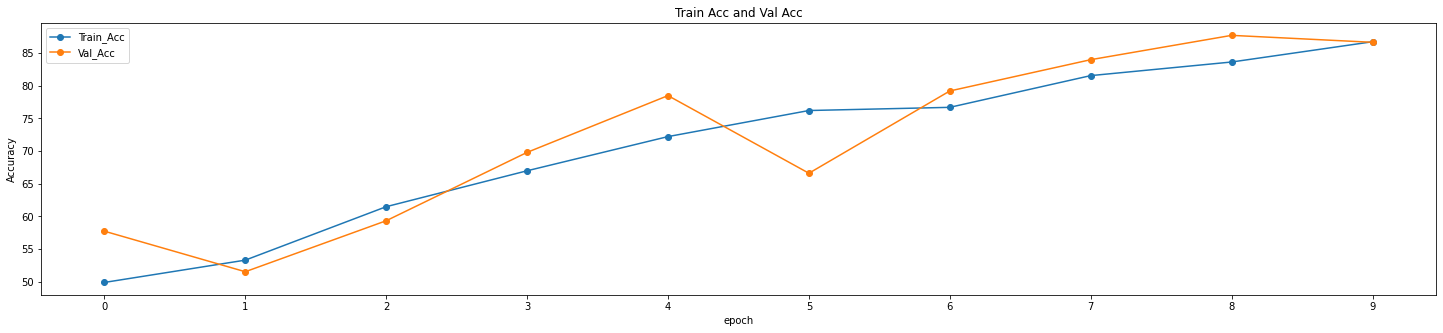

In [127]:
trainer.plot_his_acc()

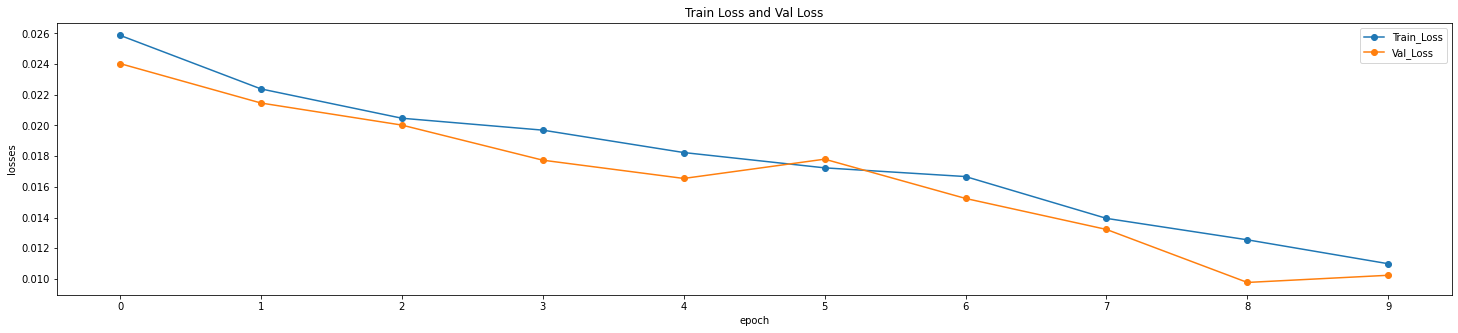

In [128]:
trainer.plot_his_loss()

In [130]:
def evaluate_model(model, loader):
    model.eval()
    pred_list = []
    label_list = []
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        running_loss=0
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            _, predictions = torch.max(outputs, 1)
            pred_list.extend(predictions.cpu().numpy())
            label_list.extend(labels.cpu().numpy())
            n_samples += labels.shape[0]
            n_correct += (predictions == labels).sum().item()
        acc = 100.0 * n_correct / n_samples
    return acc, pred_list, label_list

In [131]:
acc, pred_list, label_list = evaluate_model(model, test_loader)
print(f'Accuracy of the network on the test images: {acc} %')

Accuracy of the network on the test images: 86.70212765957447 %
